In [1]:
# import statements
import pandas as pd
import numpy as np
# for plotting
import seaborn as sns
import matplotlib.pyplot as plt
# for word tokenization
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import contractions
# for polarity and subjectivity
from textblob import TextBlob
# for readability
import textstat

# for data scaling
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()

In [2]:
# load bert features and the original text data
bert_50_train = pd.read_csv('./dataset/DistilBERT/50/train.csv')
bert_50_train_labels = bert_50_train["Label"]

# drop the label column
bert_50_train = bert_50_train.drop(columns=["Label"])

bert_50_test = pd.read_csv('./dataset/DistilBERT/50/test.csv')

bert_200_train = pd.read_csv('./dataset/DistilBERT/200/train.csv')
bert_200_train_labels = bert_200_train["Label"]

# drop the label column
bert_200_train = bert_200_train.drop(columns=["Label"])

bert_200_test = pd.read_csv('./dataset/DistilBERT/200/test.csv')

# load the original text data
train_data = pd.read_csv('./dataset/train.csv')
test_data = pd.read_csv('./dataset/test.csv')

# check shape
print(bert_50_train.shape)
print(bert_50_test.shape)
print(bert_200_train.shape)
print(bert_200_test.shape)
print(train_data.shape)
print(test_data.shape)

(430563, 8)
(101309, 9)
(430563, 8)
(101309, 9)
(430563, 3)
(101309, 3)


In [3]:
# normalize bert features

# normalize bert features
scaled_bert_50_train = standard_scaler.fit_transform(bert_50_train)
# bert_50_test = standard_scaler.transform(bert_50_test)

scaled_bert_200_train = standard_scaler.fit_transform(bert_200_train)
# bert_200_test = standard_scaler.transform(bert_200_test)

# convert to dataframe
scaled_bert_50_train = pd.DataFrame(scaled_bert_50_train, columns=bert_50_train.columns)
scaled_bert_200_train = pd.DataFrame(scaled_bert_200_train, columns=bert_200_train.columns)

In [4]:
# complexity features

training_complexity_features = pd.DataFrame()
training_complexity_features["text_length"] = train_data["Document"].apply(lambda x: len(x))
training_complexity_features["digit_count"] = train_data["Document"].apply(lambda x: sum([1 for c in x if c.isdigit()]))
training_complexity_features["special_char_count"] = train_data["Document"].apply(lambda x: sum([1 for c in x if not c.isalnum()]))

lemmatizer = WordNetLemmatizer()


def tokenize_text(document: str) -> list:
    # remove special characters, expand contractions and convert to lowercase
    # text = contractions.fix(document)
    text = document.lower()
    text = re.sub(r"[^a-zA-z0-9\s]", "", text)

    tokens = word_tokenize(text)
    
    # lemmatize the tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens

training_complexity_features["word_count"] = train_data["Document"].apply(lambda x: len(tokenize_text(x)))
training_complexity_features["unique_word_count"] = train_data["Document"].apply(lambda x: len(set(tokenize_text(x))))

# scale training complexity features
training_complexity_features = pd.DataFrame(standard_scaler.fit_transform(training_complexity_features), columns=training_complexity_features.columns)



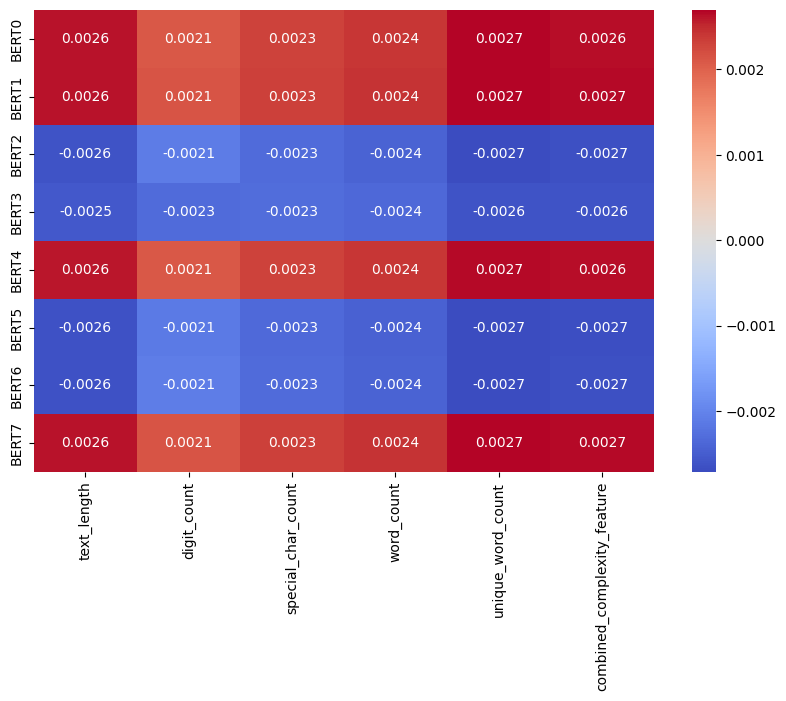

In [51]:
# check if BERT features correlate with any of the original brainstormed features
# {pearson, kendall, spearman}

def plot_bert_complexity_correlation_matrix(method = "spearman"):
    bert_complexity_correlation = pd.DataFrame()
    
    for feature in training_complexity_features.columns:
        bert_complexity_correlation[feature] = scaled_bert_50_train.corrwith(training_complexity_features[feature], method=method)
                    
    # plot the correlation matrix in one, with column names = existing features and row names = BERT features
    plt.figure(figsize=(10, 6))
    sns.heatmap(bert_complexity_correlation, annot=True, cmap="coolwarm")
    plt.show()


plot_bert_complexity_correlation_matrix("spearman")


In [7]:
# polarity and subjectivity

def extract_psycholinguistic_features(text: str):
    psycholinguistic_features = {}
    
    textBlob = TextBlob(contractions.fix(text))
    psycholinguistic_features["polarity"] = textBlob.sentiment.polarity
    psycholinguistic_features["subjectivity"] = textBlob.sentiment.subjectivity
    
    return psycholinguistic_features

training_psycholinguistic_features = train_data["Document"].apply(extract_psycholinguistic_features).apply(pd.Series)

# scale training psycholinguistic features
training_psycholinguistic_features = pd.DataFrame(standard_scaler.fit_transform(training_psycholinguistic_features), columns=training_psycholinguistic_features.columns)

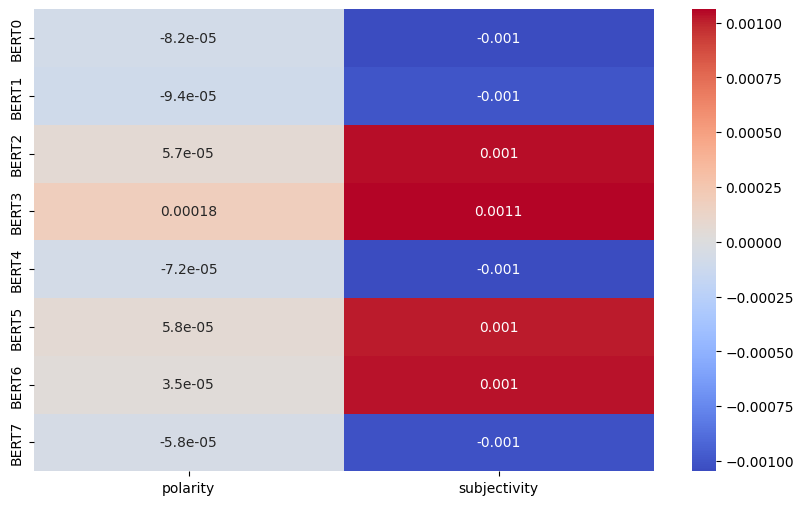

In [28]:
# check if BERT features correlate with any of the psycholinguistic features

def plot_bert_psycholinguistic_correlation_matrix(method: str = "spearman"):
    bert_polarity_correlation = scaled_bert_50_train.corrwith(training_psycholinguistic_features["polarity"], method=method)
    bert_subjectivity_correlation = scaled_bert_50_train.corrwith(training_psycholinguistic_features["subjectivity"], method=method)

    bert_psycholinguistic_correlation = pd.concat([bert_polarity_correlation, bert_subjectivity_correlation], axis=1)
    bert_psycholinguistic_correlation.columns = ["polarity", "subjectivity"]

    # plot the correlation matrix in one, with column names = existing features and row names = BERT features
    plt.figure(figsize=(10, 6))
    sns.heatmap(bert_psycholinguistic_correlation, annot=True, cmap="coolwarm")
    plt.show()
    
    
plot_bert_psycholinguistic_correlation_matrix("spearman")

In [6]:
# readability features


def extract_readability_features(text):
    readability_features = {}
    
    readability_features["gunning_fog_index"] = textstat.gunning_fog(text)
    readability_features["coleman_liau_index"] = textstat.coleman_liau_index(text)
    readability_features['linsear_write'] = textstat.linsear_write_formula(text)
    
    # Dale-Chall Readability Score
    readability_features['dale_chall_score'] = textstat.dale_chall_readability_score(text)
    
    # Flesch Reading Ease
    readability_features['flesch_reading_ease'] = textstat.flesch_reading_ease(text)
    
    # Spache Readability Score
    readability_features['spache'] = textstat.spache_readability(text)
    
    # Automated Readability Index
    readability_features['automated_readability_index'] = textstat.automated_readability_index(text)
    
    # Smog Index
    readability_features['smog_index'] = textstat.smog_index(text)
    
    # Flesch-Kincaid Grade Level
    readability_features['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(text)
    
    # RIX Readability
    readability_features['rix'] = textstat.rix(text)
    
    # McAlpine EFLAW Readability
    readability_features['mcalpine_eflaw'] = textstat.mcalpine_eflaw(text)
    
    # Gulpease Readability
    readability_features['gulpease'] = textstat.gulpease_index(text)
    
    return readability_features

training_readability_features = train_data["Document"].apply(extract_readability_features).apply(pd.Series)

# scale readability features
training_readability_features = pd.DataFrame(standard_scaler.fit_transform(training_readability_features), columns=training_readability_features.columns)

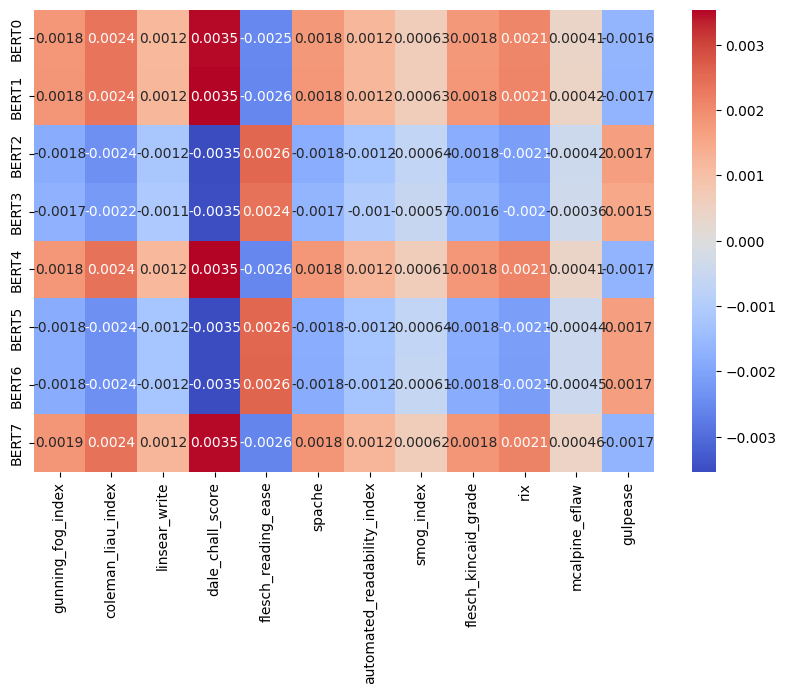

In [55]:
# check if BERT features correlate with any of the readability features

def plot_bert_readability_correlation_matrix(method: str = "spearman"):
    bert_readability_correlation = pd.DataFrame()
    
    for feature in training_readability_features.columns:
        bert_readability_correlation[feature] = scaled_bert_50_train.corrwith(training_readability_features[feature], method=method)
        
    # plot the correlation matrix in one, with column names = existing features and row names = BERT features
    plt.figure(figsize=(10, 6))
    sns.heatmap(bert_readability_correlation, annot=True, cmap="coolwarm")
    plt.show()
    
    
plot_bert_readability_correlation_matrix("spearman")

In [15]:
# tf-idf features

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=5, stop_words="english")

tfidf_train = tfidf_vectorizer.fit_transform(train_data["Document"].apply(lambda x: " ".join(tokenize_text(x))))

# scale tf-idf features
training_tf_idf_features = pd.DataFrame(standard_scaler.fit_transform(tfidf_train.toarray()), columns=[tf_idf_feature_name + "_uni" for tf_idf_feature_name in tfidf_vectorizer.get_feature_names_out()])

In [16]:
# bi-gram tf-idf

tfidf_vectorizer = TfidfVectorizer(max_features=5, stop_words="english", ngram_range=(2, 2))

tfidf_train = tfidf_vectorizer.fit_transform(train_data["Document"].apply(lambda x: " ".join(tokenize_text(x))))

# scale tf-idf features
training_tf_idf_features_bi_gram = pd.DataFrame(standard_scaler.fit_transform(tfidf_train.toarray()), columns=[tf_idf_feature_name + "_bi" for tf_idf_feature_name in tfidf_vectorizer.get_feature_names_out()])

In [17]:
# tri-gram tf-idf

tfidf_vectorizer = TfidfVectorizer(max_features=5, stop_words="english", ngram_range=(3, 3))

tfidf_train = tfidf_vectorizer.fit_transform(train_data["Document"].apply(lambda x: " ".join(tokenize_text(x))))

# scale tf-idf features
training_tf_idf_features_tri_gram = pd.DataFrame(standard_scaler.fit_transform(tfidf_train.toarray()), columns=[tf_idf_feature_name + "_tri" for tf_idf_feature_name in tfidf_vectorizer.get_feature_names_out()])

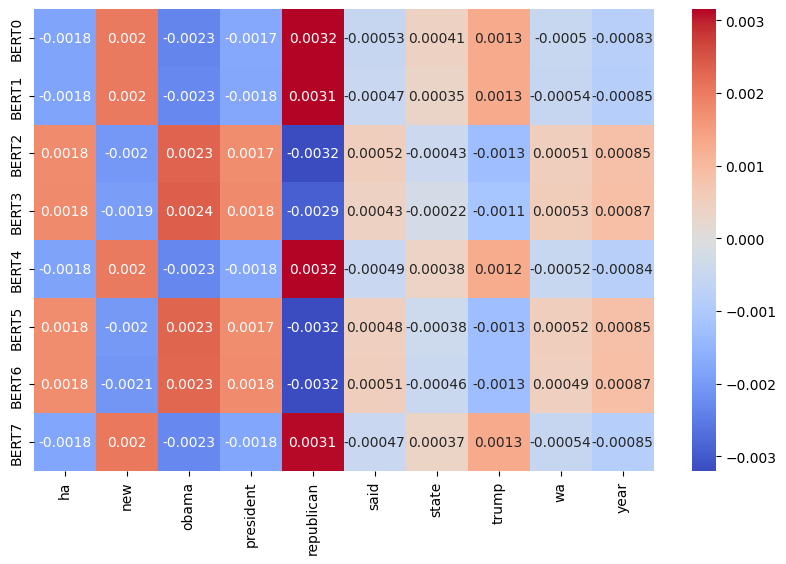

In [26]:
# check if BERT features correlate with any of the tf-idf features

def plot_bert_tf_idf_correlation_matrix(method: str = "spearman"):
    # for each tf-idf feature, calculate the correlation with each BERT feature
    bert_tf_idf_correlation = pd.DataFrame()
    for feature in training_tf_idf_features.columns:
        bert_tf_idf_correlation[feature] = scaled_bert_50_train.corrwith(training_tf_idf_features[feature], method=method)
        
    # plot the correlation matrix in one, with column names = existing features and row names = BERT features
    plt.figure(figsize=(10, 6))
    sns.heatmap(bert_tf_idf_correlation, annot=True, cmap="coolwarm")
    plt.show()
    
    
plot_bert_tf_idf_correlation_matrix("spearman")

In [11]:
# empath features for sentiment analysis

from empath import Empath

lexicon = Empath()

desired_categories = ['business', 'economics', 'money', 'tourism', 'shopping', 'leader', 'government', 'banking', 'hiking']

def extract_empath_features(text: str) -> dict:
    return lexicon.analyze(text, categories=desired_categories, normalize=True)

training_empath_features = pd.DataFrame(train_data["Document"].apply(extract_empath_features).tolist()).rename(columns=lambda x: x + "_empath")

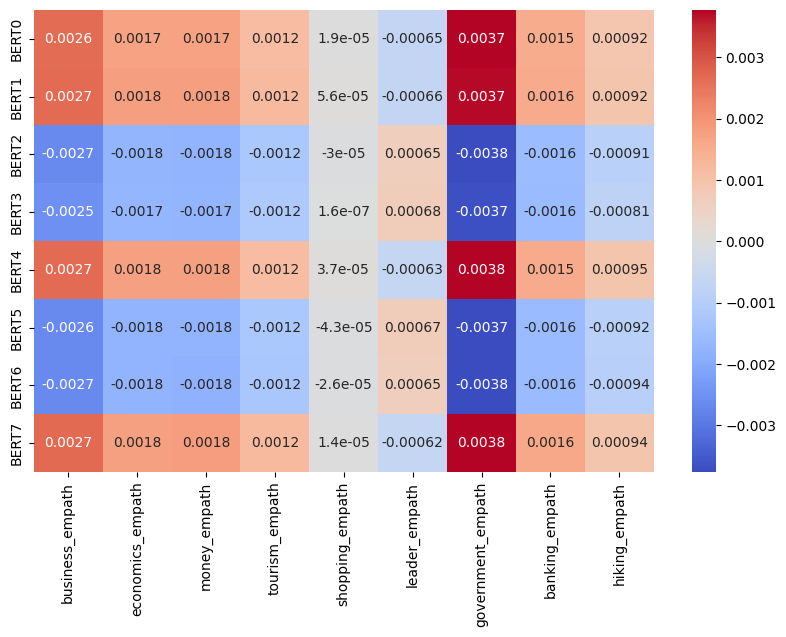

In [57]:
# check if BERT features correlate with any of the empath features

def plot_bert_empath_correlation_matrix(method: str = "spearman"):
    # for each empath feature, calculate the correlation with each BERT feature
    bert_empath_correlation = pd.DataFrame()
    for feature in training_empath_features.columns:
        bert_empath_correlation[feature] = scaled_bert_50_train.corrwith(training_empath_features[feature], method=method)
        
    # plot the correlation matrix in one, with column names = existing features and row names = BERT features
    plt.figure(figsize=(10, 6))
    sns.heatmap(bert_empath_correlation, annot=True, cmap="coolwarm")
    plt.show()
    
    
plot_bert_empath_correlation_matrix("spearman")

In [9]:
def extract_vad_features(text: str, vad_scores: pd.DataFrame, vad_vocab: set):
    tokens = tokenize_text(text)
    
    # check for "no" and :not existence
    negation = -1 if "no" in tokens or "not" in tokens else 1
    
    valid_tokens = [token for token in tokens if token in vad_vocab]
    
    if len(valid_tokens) == 0:
        return {"valence": 0, "arousal": 0, "dominance": 0}
    
    vad_length = len(valid_tokens)
    
    text_vad = vad_scores.loc[valid_tokens].sum().values * negation
    
    emotion_features = {}
    
    emotion_features["valence"] = text_vad[0] / vad_length
    emotion_features["arousal"] = text_vad[1] / vad_length
    emotion_features["dominance"] = text_vad[2] / vad_length
                      
    return emotion_features
    

vad_scores=pd.read_csv("./dataset/vad-nrc.csv", index_col='Word')
vad_vocab = set(vad_scores.index)

training_emotion_features = train_data["Document"].apply(lambda x: extract_vad_features(x, vad_scores, vad_vocab)).apply(pd.Series)

# scale emotion features
training_emotion_features = pd.DataFrame(standard_scaler.fit_transform(training_emotion_features), columns=training_emotion_features.columns)

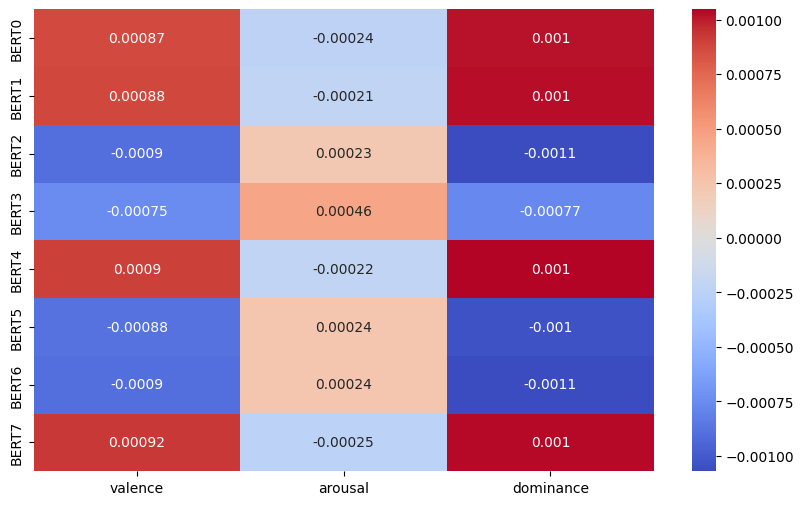

In [62]:
# check if BERT features correlate with any of the emotion features

def plot_bert_emotion_correlation_matrix(method: str = "spearman"):
    # for each emotion feature, calculate the correlation with each BERT feature
    bert_emotion_correlation = pd.DataFrame()
    for feature in training_emotion_features.columns:
        bert_emotion_correlation[feature] = scaled_bert_50_train.corrwith(training_emotion_features[feature], method=method)
      
    # plot the correlation matrix in one, with column names = existing features and row names = BERT features
    plt.figure(figsize=(10, 6))
    sns.heatmap(bert_emotion_correlation, annot=True, cmap="coolwarm")
    plt.show()
    
    
plot_bert_emotion_correlation_matrix("spearman")

In [18]:
# for each BERT feature, find the top 5 positively correlated features together with their respective correlation values
def find_top_correlated_features(bert_features: pd.DataFrame, existing_features: pd.DataFrame, top_n: int, method: str = "spearman"):
    top_correlated_features = {}
    
    for feature in bert_features.columns:
        top_correlated_features[feature] = existing_features.corrwith(bert_features[feature], method=method).nlargest(top_n).to_dict()
        
    return top_correlated_features

feature_df = pd.concat([training_complexity_features, training_psycholinguistic_features, training_readability_features, training_tf_idf_features, training_tf_idf_features_bi_gram, training_tf_idf_features_tri_gram, training_empath_features], axis=1)

top_correlated_features = find_top_correlated_features(scaled_bert_50_train, feature_df, 5, "spearman")

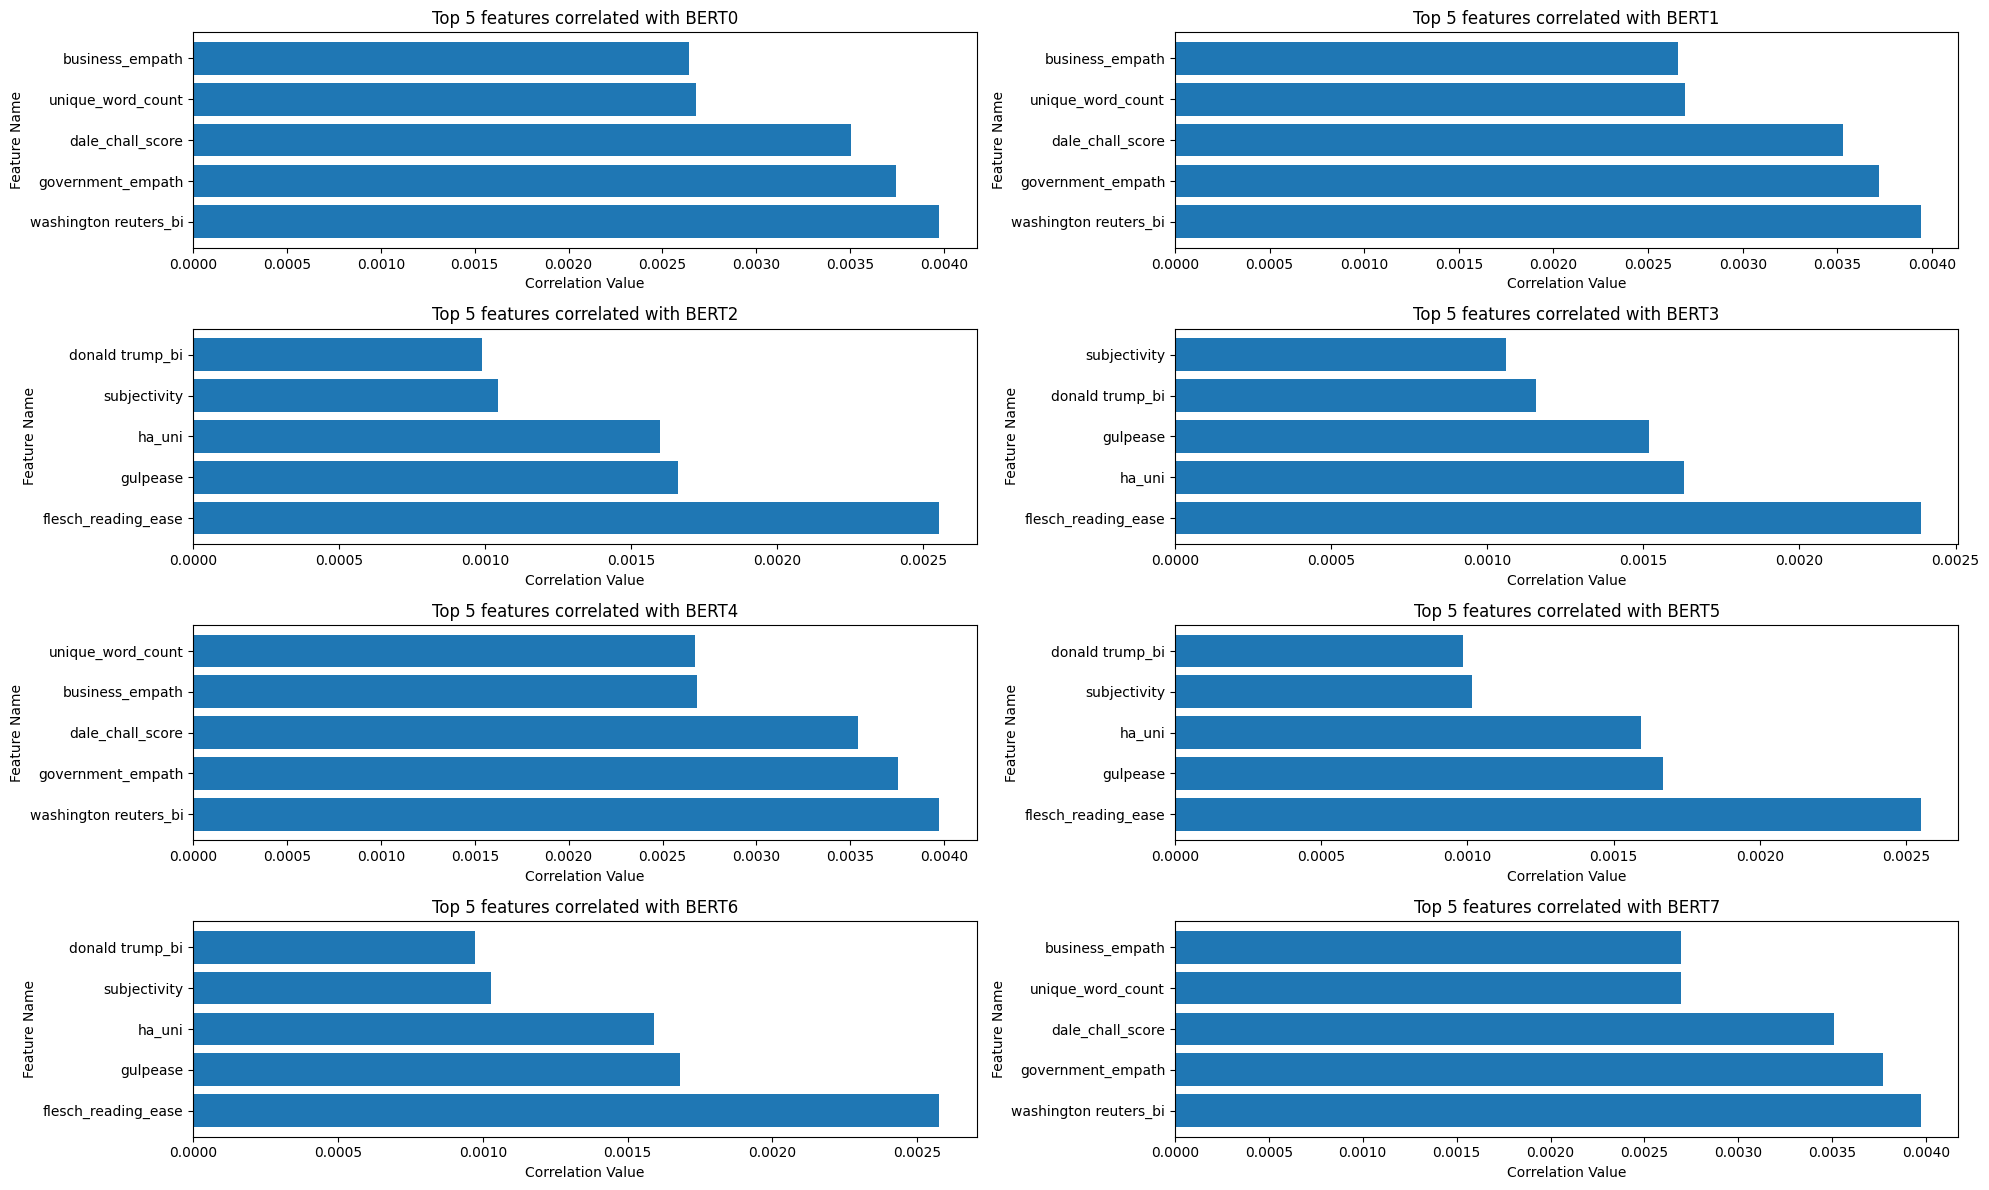

In [19]:
fig, axs = plt.subplots(len(top_correlated_features) // 2, 2, figsize=(20, 12))

axs = axs.flatten()

for i, (feature, correlated_features) in enumerate(top_correlated_features.items()):
    ax = axs[i]
    ax.barh(list(correlated_features.keys()), list(correlated_features.values()))
    ax.set_title(f"Top 5 features correlated with {feature}")
    ax.set_xlabel("Correlation Value")
    ax.set_ylabel("Feature Name")

plt.tight_layout()
plt.show()